In [7]:
import json
import itertools
import pathlib

import geojson
import scipy.stats
import toolz
import toolz.curried
import pydash
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs

In [3]:
with open('/Users/baart_f/Downloads/BOX099_transects_rates.json') as f:
    features = geojson.load(f)
with open('/Users/baart_f/Downloads/BOX187_transects_rates.json') as f:
    features = geojson.load(f)

In [4]:
features['features'][0]['properties'].keys()
features['features'][0]['geometry']


{"coordinates": [[17.966394475619165, 54.8245417781275], [17.96443101967979, 54.834828544733064]], "type": "LineString"}

In [5]:
sand_features = list(toolz.filter(lambda x: pydash.get(x, 'properties.flag_sandy') == 'True', features['features']))
grouped = toolz.groupby(
    lambda x: pydash.get(x, 'properties.country_id'),
    sand_features
)

In [8]:

for country, country_features in grouped.items():
    path = pathlib.Path(country).with_suffix('.json')
    if path.exists():
        with path.open() as f:
            data = json.load(f)
    else:
        data = {}
    change_rates = [
        pydash.get(feature, 'properties.change_rate')
        for feature
        in country_features
    ]
    coordinates = [
        pydash.get(feature, ['geometry', 'coordinates'])
        for feature
        in country_features
    ]
    rates = np.ma.masked_equal(change_rates, -999)
    freqs, bins = np.histogram(rates[~rates.mask], bins=np.linspace(-20, 20, num=51))
    summed_freqs = data.get('freqs', np.zeros_like(freqs)) + freqs
    data['freqs'] = summed_freqs.tolist()
    data['coordinates'] = data.get('coordinates', []) + coordinates
    # just overwrite verytime
    data['bins'] = bins.tolist()
    data['country'] = country
    with path.open('w') as f:
        json.dump(data, f)
    
    

In [9]:

path = pathlib.Path('GAB').with_suffix('.json')
path.exists()

False

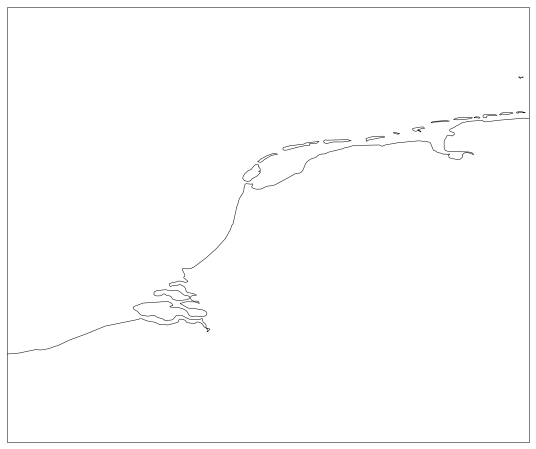

In [10]:
fig, ax = plt.subplots(
    subplot_kw=dict(
        projection=cartopy.crs.PlateCarree()
    ), 
    figsize=(13, 8)
)
ax.set_extent([2, 8, 50, 55], cartopy.crs.PlateCarree())
ax.coastlines('10m')

In [11]:
path = pathlib.Path('NLD.json')
data = json.load(path.open())
# find plot point
xy_line = np.array(data['coordinates'])
x, y = xy_line[:, 0, 0], xy_line[:, 1, 0]

x_gt_y = (x.max() - x.min()) > (y.max() - y.min())
if x_gt_y:
    1 + 1
    
median = np.median(x)
sort_idx = np.argsort(x)
# np.searchsorted(x, median, sorter=np.sort)
sorted_idx = np.searchsorted(x[sort_idx], median)
idx = sort_idx[sorted_idx]
xy_line[idx]

array([[  4.61718773,  52.56825875],
       [  4.59940751,  52.56982636]])

0.436197954948 0.513651749562


/Users/baart_f/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


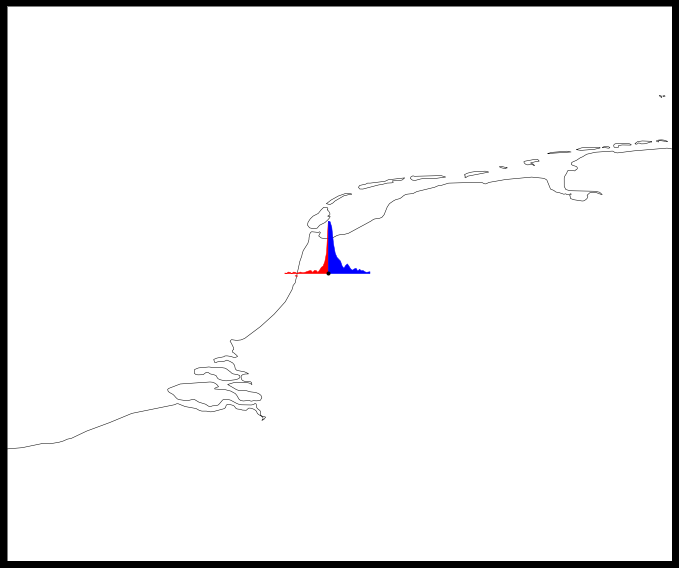

In [56]:
fig, ax = plt.subplots(
    subplot_kw=dict(
        projection=cartopy.crs.PlateCarree()
    ), 
    figsize=(13, 8)
)
extent = [2, 8, 50, 55]
ax.set_extent(extent, cartopy.crs.PlateCarree())
ax.coastlines('10m')
transect = xy_line[idx]
lon, lat = transect[0, 0], transect[0, 1]

ax.plot(transect[:, 0], transect[:, 1], 'r-')
# does not show up
# import matplotlib.transforms
# import mpl_toolkits.axisartist.floating_axes
# helper = mpl_toolkits.axisartist.floating_axes.GridHelperCurveLinear(transform, extremes=(0, 10, 0, 10))
# ax1 = mpl_toolkits.axisartist.floating_axes.FloatingSubplot(fig, 111, grid_helper=helper)

x = (lon - extent[0])/(extent[1] - extent[0])
y = (lat - extent[2])/(extent[3] - extent[2])
print(x, y)
ax1 = fig.add_axes([x, y, 0.1, 0.1])
transform = matplotlib.transforms.Affine2D().rotate(30)
ax1.get_transform()
ax1.set_transform(transform)
ax1.plot(0.0, 0.0, 'k.')
ax1.axis('off')

x = np.array(data['bins'])[:-1]
freqs = np.array(data['freqs'])
x_erosion = x[x<=0]
y1_erosion = freqs[x<=0]
y0_erosion = np.zeros_like(y1_erosion)
ax1.fill_between(x_erosion, y0_erosion, y1_erosion, color='red')
x_accretion = x[x>=0]
y1_accretion = freqs[x>=0]
y0_accretion = np.zeros_like(y1_accretion)
ax1.fill_between(x_accretion, y0_accretion, y1_accretion, color='blue')

# ax1.bar(data['bins'][:-1], data['freqs'])
# ax1.bar(data['bins'][:-1], -np.array(data['freqs']))
ax.set_xlim()
ax.set_ylim()
fig.tight_layout()



In [ ]:

kde = scipy.stats.gaussian_kde(rates[~rates.mask])
x = np.linspace(-20, 20, num=51)
plt.plot(x, kde.evaluate(x))

x_erosion = x[x<=0]
y1_erosion = kde.evaluate(x_erosion)
y0_erosion = np.zeros_like(y1_erosion)
plt.fill_between(x_erosion, y0_erosion, y1_erosion, color='red')
x_accretion = x[x>=0]
y1_accretion = kde.evaluate(x_accretion)
y0_accretion = np.zeros_like(y1_accretion)
plt.fill_between(x_accretion, y0_accretion, y1_accretion, color='blue')

In [ ]:
# separated countries
# - files per country
# - attached countries, update country file per box
# - ignore separated islands for first version

# missing countries
# - first version, put in unknown countries
# - second version: extend countries manually 


# store what per country
# - option1: binned frequency + density estimate (min, max)
# - chosen: np.histogram update per file, fixed bins (-20, 20)


# skewed distributions
# - option1: 95 percentile
# - chosen: -20, 20 


# location for the chart
# - 80% automatic (pick a middle transect, biggest range y or x)
# - 20% manual 

# countries with too long coastlines (only VS, Australia, Russia?)
# - manual
